In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import time
import subprocess
import pandas as pd

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [3]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [4]:
from google.cloud import storage

In [5]:
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [6]:
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

### Read Data

In [8]:
tweets_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_processed')

23/03/10 18:40:27 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
tweets_df.count()

13128895

In [9]:
tweets_df.columns

['user_description',
 'user_favourites_count',
 'user_followers_count',
 'user_friends_count',
 'user_id',
 'user_name',
 'user_protected',
 'user_screen_name',
 'user_statuses_count',
 'user_verified',
 'user_withheld_in_countries',
 'user_location',
 'tweet_date',
 'retweeted_status',
 'is_retweet',
 'is_reply',
 'tweet_id',
 'retweeted_from',
 'tweet_text',
 'quoted_status',
 'hashtags',
 'tweet_coordinates',
 'retweet_count',
 'retweeted_from_name',
 'retweeted_from_description']

## Differentiating the Original tweets / Retweets from a sample of nearly 13 million tweets

In [10]:
overall_count = tweets_df.select('is_retweet')

In [11]:
overall_count = overall_count.groupby(f.col('is_retweet')).agg(f.count('*').alias('count'))

In [12]:
overall_count

is_retweet,count
true,9172744
false,3956151


In [17]:
overall_count = overall_count.withColumn("is_retweet", f.when(f.col("is_retweet") == "true", "Retweet").otherwise("Original Tweet"))

In [18]:
count_chart = overall_count.toPandas()

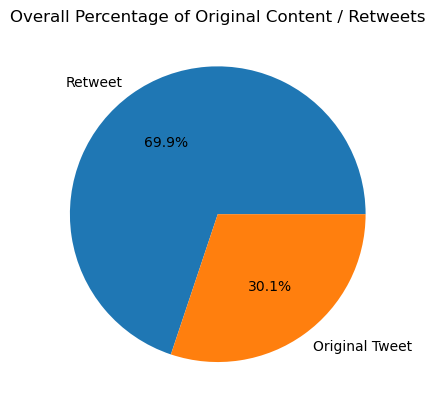

In [19]:
import matplotlib.pyplot as plt

plt.pie(count_chart["count"], labels=count_chart["is_retweet"], autopct='%1.1f%%')
plt.title("Overall Percentage of Original Content / Retweets")
plt.show()

## Classifying Twitterers into Categories

In [9]:
categ_news = ['journal','times','daily','media','news', "Daily", "coverage", "TOI", 'Times', 'Media', 'News', 'Network', 'Journal', 'reporter', 'Reporter']
categ_news_reg ='|'.join(["(" + c +")" for c in categ_news])

categ_govt = ['republic','Republic','Congress', 'Government', 'Senator','Constitution','congress','parliament','senat','president','democr',
            'prime minister','constitution', 'constituency','mla','gov','u.s.','united states']
categ_govt_reg ='|'.join(["(" + c +")" for c in categ_govt])

categ_celeb = ['actor','Actor','singer','Singer','Musician', 'musician','writer','Writer','Actress','actress','Author','author','Athlete','golfer', 'sports', 'athlete', 'cricket', 'football', 'basketball']
categ_celeb_reg ='|'.join(["(" + c +")" for c in categ_celeb])

categ_edu = ['school','university','University', 'School', 'College','research','teaching','teaches', 'edu','college','master', 'science', 'k12', 'k-12', 'K12', 'K-12',
           'graduate','undergraduate','elementary', 'learn','learning', 'course curriculum', 'higher education', 'secondary education', 'primary education']
categ_edu_reg ='|'.join(["(" + c +")" for c in categ_edu])

categ_nonprofit = ['nonprofit', 'ngo', 'charity', 'fundrais', 'nonprofit org', 'foundation', 'charitable trust','non profit', "Non-profit", "non-profit"]
categ_nonprofit_reg ='|'.join(["(" + c +")" for c in categ_nonprofit])

categ_influencer = ['activist','Activist', 'influencer', 'Influencer','author', 'story teller', 'life coach', 'marketing', 'branding', 'celebrity', 'art'
                'story', 'tiktok', 'dancer','Dancer' , 'therapist', 'social media personality', 'comedian', 'fitness', 'trainer', 'model'
               'fashion', 'social media', 'bestselling','Gamer', 'lifestyle', 'beauty', 'healthy', 'health', 'content creator', 'creator', 'gamer',
               'streamer', 'creativity', 'living', 'blogger','Blogger','Content','Creator', 'blogging', 'vegan', 'animal lover', 'artist']
categ_influencer_reg ='|'.join(["(" + c +")" for c in categ_influencer])

tweets_categ = tweets_df\
.withColumn('Category',\
            when(tweets_df['user_verified'] == False, 'Other')\
           .when((tweets_df['user_name'].rlike(categ_news_reg)) | (tweets_df['user_description'].rlike(categ_news_reg)), 'News')\
           .when((tweets_df['user_name'].rlike(categ_govt_reg)) | (tweets_df['user_description'].rlike(categ_govt_reg)), 'Government')\
           .when((tweets_df['user_description'].rlike(categ_celeb_reg)) & (tweets_df['user_followers_count'] > 25000), 'Celebrity')\
           .when((tweets_df['user_name'].rlike(categ_edu_reg)) | (tweets_df['user_description'].rlike(categ_edu_reg)), 'Educational_institute')\
           .when((tweets_df['user_name'].rlike(categ_nonprofit_reg)) | (tweets_df['user_description'].rlike(categ_nonprofit_reg)), 'Nonprofit_organization')\
           .when((tweets_df['user_name'].rlike(categ_influencer_reg)) | (tweets_df['user_description'].rlike(categ_influencer_reg)), 'Influencer')\
           .otherwise('Other'))



In [27]:
tweets_categ.limit(5)

user_description,user_favourites_count,user_followers_count,user_friends_count,user_id,user_name,user_protected,user_screen_name,user_statuses_count,user_verified,user_withheld_in_countries,user_location,tweet_date,retweeted_status,is_retweet,is_reply,tweet_id,retweeted_from,tweet_text,quoted_status,hashtags,tweet_coordinates,retweet_count,retweeted_from_name,retweeted_from_description,Category
ui ux design stud...,587,123,553,1309078993442873344,Iamsiglar,false,GoodnessMadume1,356,false,[],"port harcourt, ni...",2022-09-04 10:52:34,null,false,true,1566378682549260288,null,aaronakpuphilip s...,null,[],null,null,null,null,Other
im counting on yo...,11632,341,458,1530893925803622401,hannah🌻ᥫ᭡,false,lvchdvmp,5624,false,[],archen's heart,2022-09-04 10:52:44,"{null, Sat Sep 03...",true,false,1566378724135555072,imzarvinnn,senior high schoo...,null,[],null,21065,𝗺𝗶𝗻,logcast imzarvinn...,Other
she her ...,59,1,91,1398282464854827012,kopi//buat baca au,false,doyiea_,621,false,[],null,2022-09-04 10:52:46,"{null, Sat Sep 03...",true,false,1566378734529101824,imzarvinnn,senior high schoo...,null,[],null,21067,𝗺𝗶𝗻,logcast imzarvinn...,Other
physics phd soft...,5079,487,584,952328127430189056,Stephen Morris,false,EosPengwern,9188,false,[],"pengwern, swydd a...",2022-09-04 10:52:48,"{null, Sun Sep 04...",true,false,1566378739969179648,CConcern,breaking school c...,null,[],null,2,Christian Concern,speaking of jesus...,Other
more than 1k wor...,95,520,182,1307586299893702656,ACADS COMMISSIONE...,false,PaperupPh,820,false,[],10am-10pm,2022-09-04 10:52:49,null,false,true,1566378745539469312,null,jenqissante bs ps...,"{null, Wed Feb 23...",[],null,null,null,null,Other


In [10]:
pd.set_option('display.max_colwidth', 200)

## Identify the most prolific / influential Twitterers
### 1) By message volume (original content)

In [12]:
message_volume = (tweets_categ.filter(~f.col('is_retweet'))
                          .filter(~f.col('is_reply'))
                          .groupby('user_id')
                          .agg(
                              f.max('user_name').alias('user_name'),
                              f.max('user_description').alias('user_description'),
                              f.max('tweet_text').alias('tweet_text'),
                              f.max('Category').alias('Category'),
                              f.count('tweet_id').alias('count')
                          )
                          .select(['user_name', 'user_description','tweet_text', 'Category','count'])
                          .orderBy('count', ascending=False)).toPandas()

In [13]:
message_volume.head(5)

,user_name,user_description,tweet_text,Category,count
0,NJSchoolJobs.com,the leading advertiser of education jobs for new jerseys schools since 1999 nj teaching administrative coaching education teachingjobs newjersey,wrestling assistant coach grades 6 7 8 matawan aberdeen regional school district aberdeen nj proper nj certification required nj education teachingjobs,Other,7178
1,LUV 22 SPORTS,welcom tv listing for all live sports enjoy your watching live sports football basketball and many more click the link below the description,zeeland west high school vs muskegon high school 2022 mhsaa football regional official live 11 12 2022 1 00 pm sztjkdjnsc,Other,5010
2,sport99,welcom tv listing for all enjoy your watching live sports football basketball and more click the link below the description,yuba city high school vs vista del lago high school folsom 2022 cifsjs football playoffs watch friday november 04 2022 9 00 pm orbaymcwhf,Other,4715
3,AGS-SPORTS89,enjoy your watching,york catholic high school vs notre dame high school green pond 2022 piaa 2a girls volleyball semifinal official live 11 15 2022 7 00 pm lkxhkyenla,Other,2873
4,Larry L. Robinson - Free - Education - University,is a 17 course curriculum that teaches you how to find the right financial opportunities to fund your higher education,free education university find scholarships grants specifically tailored personality type hobbies college major much link bio,Other,2500


### 2) By message retweet 

In [13]:
retweet_volume = (tweets_categ.filter(f.col('is_retweet'))
                          .filter(~f.col('is_reply'))
                          .groupby(['retweeted_from', 'tweet_text', 'Category']) # For each user_name and tweet_text combination
                          .agg(
                              f.max('retweeted_from_description').alias('user_description'),
                              f.max('retweet_count').alias('retweet_count') # Take the max value the retweet_count for each combination
                          )
                          .orderBy('retweet_count', ascending=False)).toPandas()

In [14]:
retweet_volume.head(10)

,retweeted_from,tweet_text,Category,user_description,retweet_count
0,aambxt,parents push u college education mad u get educated challenge outdated beliefs lol,Other,blm,233417
1,ManLikeGinola,lmao school board meeting zoom safe meet person discuss theyre gonna send thousands kids back school,Other,None,181905
2,camiconleche,school discovered undocumented scholarship amp state tuition taken away told papi going drop amp work instead papi told cut arm dropped made work today graduated amp undocugrad,Other,undocuqueer femme cap sag higher ed pro usf 18 csu 20 she her delightfully unhinged blacklivesmatter,153611
3,jordannjust,please watch sex education school system failed teach us thread part 1 vulva,Other,jordannjustfitness gmail com art music earth enthusiast famu alumna,148734
4,thomas_violence,love little cultural differences like americans super offended word cunt australia super offended school children slaughtered automatic weapons,Other,producer and least kempt host of boontavista its a podcast ive heard theres a community of coelacanths in the brisbane river,143723
5,thomas_violence,love little cultural differences like americans super offended word cunt australia super offended school children slaughtered automatic weapons,News,producer and least kempt host of boontavista its a podcast ive heard theres a community of coelacanths in the brisbane river,143552
6,crumbyj,change student reaches high school either,Other,assistant principal at father ryan high school,122556
7,spinubzilla,high school gym teacher asked us thought smartest teacher school guessed ap chem teacher precalc teacher ap physics teacher etc goes nope get paid guys play dodgeball day,Other,patron saint of sad boys she her writer of tinyfairytales,120710
8,LisPower1,story wild ice created fake university enticed foreign born students attend charged money arrested deported students come legally student visas since school fake visas werent valid,Other,director of media intelligence mmfa philly born flyeaglesfly f m alum former tfa miami views are mine alone,115486
9,loeytaro,heres thread missing children robb elementary school texas see thread youre obligated retweet,Other,you look just like a dream the prettiest man ive ever seen,114800


In [13]:
retweet_volume_ver = (tweets_categ.filter(f.col('is_retweet'))
                          .filter(~f.col('is_reply'))
                          .filter(f.col('user_verified') == True)
                          .groupby(['retweeted_from', 'tweet_text']) # For each user_name and tweet_text combination
                          .agg(
                              f.max('retweeted_from_description').alias('user_description'),
                              f.max('Category').alias('Category'),
                              f.max('retweet_count').alias('retweet_count') # Take the max value the retweet_count for each combination
                          )
                          .orderBy('retweet_count', ascending=False)).toPandas()

In [14]:
retweet_volume_ver.head(10)

,retweeted_from,tweet_text,user_description,Category,retweet_count
0,thomas_violence,love little cultural differences like americans super offended word cunt australia super offended school children slaughtered automatic weapons,producer and least kempt host of boontavista its a podcast ive heard theres a community of coelacanths in the brisbane river,Other,143552
1,loeytaro,heres thread missing children robb elementary school texas see thread youre obligated retweet,you look just like a dream the prettiest man ive ever seen,Other,93008
2,mattxiv,florida high school class president zander moricz told school would cut microphone said gay grad speech replaced gay curly hair awe,jewish homo w very long nails he they,Other,71948
3,ClintSmithIII,elementary school children woke morning ate favorite cereal tied shoes double knots laughed friends bus dozen dead normal way keep way,writer theatlantic author of counting descent and how the word is passed,Other,70293
4,RexChapman,young man severely colorblind studying colorblindness class school principal brought glasses allowed youngster see color first time twitter content,i hold the microphone like a grudge,Celebrity,59774
5,NasimiShabnam,male university students walked exam protest taliban decision ban female students university education several male professors also resigned far must happen across country,former policy special advisor to minister for afghan resettlement minister for refugees cfofafghanistan agent tbp agency,Other,58708
6,QasimRashid,keenan anderson 31 year old high school teacher amp father stopped la police help accident instead cuffed pinned amp tased repeatedly begged stop keenan died cardiac arrest excessive tasing crime ...,human rights lawyer author dad jokes host of the qasim rashid show on sirius xm channel 126 sundays 10am est,Other,57532
7,GunnelsWarren,average weekly wages 1973 873 2022 813 median home 1973 30 200 2022 433 100 monthly rent 1973 108 2022 2 002 tuition fees university california 1973 150 2022 13 104 boomer cant slackers pay colleg...,majority staff director for budget chairman sensanders views expressed here are my own one of bernie s guys blatantly pro union aka chief of receipts,Other,55820
8,MichaelWarbur17,2006 high school english teacher asked students write famous author amp ask advice kurt vonnegut one respond reply doozy,actor the strays all about eve corrie etc cinephile drummer posting stuff i like no pandering substack on movies at,Other,53793
9,kaithurz,school counselor called ask aware daughter planned amp led student protest today 100 students walked 3rd period hold blm rally yard bc feel teachers treat black students different amp unfairly 12,cold could be more approachable but cute,Other,43919


## Who are these Twitterers?

In [22]:
distinct_users = tweets_categ.select('user_id').distinct().count()
distinct_users

5242316

In [23]:
type_perc = tweets_categ.groupby('Category').agg(((f.countDistinct('user_id') / distinct_users) * 100).alias('Percentages')).orderBy('Percentages', ascending=True).toPandas()
type_perc.Category = type_perc.Category.astype('str')
type_perc

,Category,Percentages
0,Nonprofit_organization,0.011903
1,Celebrity,0.043416
2,Influencer,0.050340
3,Educational_institute,0.096904
4,Government,0.174713
5,News,0.367319
6,Other,99.308683


In [11]:
tweets_categ = tweets_categ.na.fill(value='Other',subset=['Category'])

In [12]:
tweets_categ_ver = tweets_categ.filter((tweets_categ['user_verified'] == True))

In [20]:
#Considering only the distinct users to avoid those who may have tweeted multiple times

distinct_users = tweets_categ_ver.select('user_id').distinct().count()
distinct_users

58155

In [30]:
type_perc = tweets_categ_ver.groupby('Category').agg((f.countDistinct('user_id').alias('Count'))).orderBy('Count', ascending=True).toPandas()
type_perc.Category = type_perc.Category.astype('str')
type_perc

,Category,Count
0,Nonprofit_organization,624
1,Celebrity,2276
2,Influencer,2639
3,Educational_institute,5080
4,Government,9159
5,News,19256
6,Other,21073


Text(0.5, 1.0, 'Percentage of Twitterers by Category')

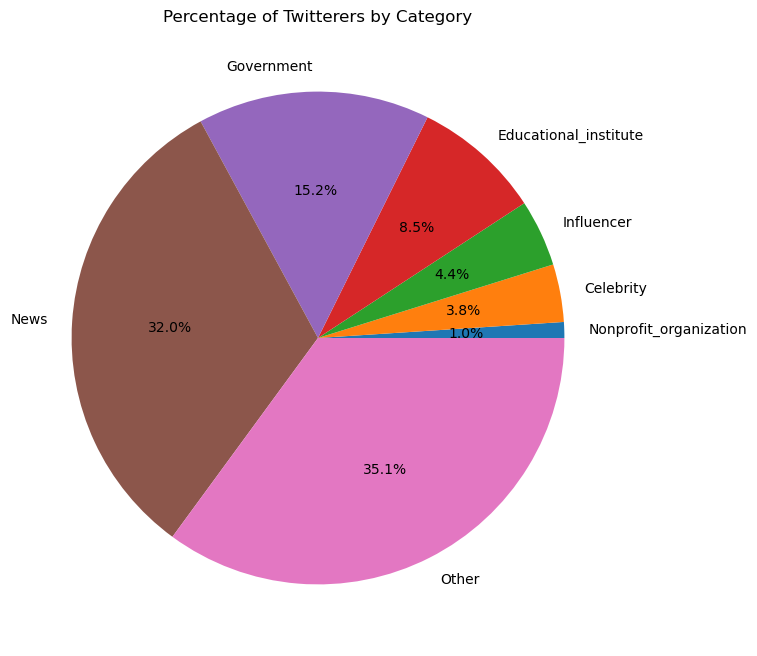

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(type_perc["Count"], labels=type_perc["Category"], autopct='%1.1f%%')
ax.set_title("Percentage of Twitterers by Category")

## Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

In [13]:
message_by_group = (tweets_categ_ver.filter(~f.col('is_retweet'))
                          .filter(~f.col('is_reply'))
                          .groupby('Category')
                          .agg(
                              f.countDistinct('tweet_id').alias('count'),
                              f.max('user_name').alias('user_name'),
                              f.max('user_description').alias('user_description'),
                              f.max('tweet_text').alias('tweet_text')
                          ).select(['user_name','user_description','tweet_text','Category','count'])
                          .orderBy('count', ascending=True)).toPandas()
message_by_group

,user_name,user_description,tweet_text,Category,count
0,🎅🏿🎄 Christmas Burger 🎄🎅🏿,your voice at the united nations the only un accredited ngo that monitors the world body defends human rights and fights dictatorships and double standards,zp pandhari village school teachers makes proud dedication amp perseverance towards village kids teachers day1 pandhari school construction amp helped build school humble request dmaurangabadmh vi...,Nonprofit_organization,1039
1,🦃 𝐬𝐡𝐚𝐰𝐧𝐚,your partner in a healthier future for all,yuppie parents insisting private school educated children learn mandarin woulda thunk thing thing might coming end decade two,Influencer,2208
2,🦀 Jon 🦀 Schwarz 🦀,your no 1 source for cincinnati and kentucky area sports including bearcats bengals reds via the enquirer sports department,zero emission vehicles future transportation university windsor working electric vehicle project highlight world leading capabilities ev research manufacturing evweek,Celebrity,2460
3,🚀 Molly Cain,zonal office of press information bureau pib india m o information broadcasting mib india government of india mumbai maharashtra,zummar iraq secondary school girls reopened october usaid provided desks whiteboards office tables amp chairs photocopy machines usaid support school would remained deserted said khadija ali schoo...,Government,13220
4,🚌Shawn M. Donaghy🚌,your source for university of iowa hawkeye sports powered by presscitizen and dmregister,zucker family school education selected recipient 2022 frank murray leadership recognition continuous improvement ranked one best master bachelor programs education south carolina,Educational_institute,17354
5,🦋🦋🦋,zzp expert emeritus schrijft en redigeert nog wat voor oude trouwe klanten verder egyptologie paard hond koken genieten,zozan yasar kurdish journalist turkey denied access education zozan taught read write went university get degree working journalist zozanyasar imix uk refugeeweek refugeeweek2022 healingtogether,Other,23992
6,🤷🏻‍♀️Kelly Rose🤷🏻‍♀️,zimbabwe broadcasting corporation first with the news about zimbabwe and africa,zzero sufuri good school learning kind school one physically somewhere learning,News,57085


In [18]:
#Checking original messages for verified users only
tweets_categ_ver.filter(~f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Government')\
                .groupby('user_id')\
                .agg(
                    f.countDistinct('tweet_id').alias('count'),
                    f.max('user_name').alias('user_name'),
                    f.max('tweet_text').alias('tweet_text')          
                          )\
                .select(['user_name', 'tweet_text', 'count'])\
                .orderBy('count', ascending=False).limit(10).toPandas()

,user_name,tweet_text,count
0,Mirror Now,video students dancing engineering college mangaluru went viral social media students seen dancing bollywood song college event wearing burqa sparked row allegedly hurt religious sentiments watch,113
1,EduMinKenya,vice chancellor university nairobi prof kiama nyandarua deputy governor mathora mwangi following presidential working party education reforms forum ol kalou secondary school nyandarua county today,95
2,U.S. Department of Education,want make positive impact consider mentoring student research shows youth mentees experience increased hs graduation rates higher college enrollment rates improved self esteem learn mentoringmonth,65
3,Welsh Government Education,world cup educational packs primary secondary school teachers bbcbitesize resources developed teachers collaboration fawales accompany curriculumforwales walesworldcuppack,57
4,"Wright State University (Dayton, OH)",wrightstate university hosted women stemm mentoring event student union atrium april 13 read story,57
5,Education Cannot Wait,would rather go regular school w children teachers amp nurses hospital kind amp make ok shahd ecw supported determination schools bringing education children w chronic illnesses palestine unesco,47
6,Sindh School Education,weekly progress review meeting school education amp literacy department held chair secretary se amp ld mr ghulam akbar laghari today 27th july 2022 committee room seld govt sindh special secretary...,45
7,The Washington Post,wave new state laws meant alter students learn rights school taken effect across nearly half country washington post analysis found part rising battle cultural values american education,42
8,DC PCSB #DCcharterProud,yesterday dr walker davis joined mayorbowser education leaders across dc encourage families get children vaccinated ahead 2022 2023 school year learn dcs immunization requirements k 12 students,41
9,Miami Herald,wearing native american regalia kept illinois high school student grad walk,40


In [21]:
tweets_categ_ver.filter(~f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'News')\
                .groupby('user_id')\
                .agg(
                    f.countDistinct('tweet_id').alias('count'),
                    f.max('user_name').alias('user_name'),
                    f.max('tweet_text').alias('tweet_text')          
                          )\
                .select(['user_name', 'tweet_text', 'count'])\
                .orderBy('count', ascending=False).limit(5).toPandas()

,user_name,tweet_text,count
0,Hindustan Times,woman kashmir studying mbbs college bangladesh died accident neighbouring country prompting former jammu kashmir cms mehbooba mufti amp omar abdullah urge mea help family repatriation process,226
1,The Washington Times,yeshiva university allows torah friendly lgbtq club school fights pride group lawsuit,212
2,U.S. News Education,wondering whether takes succeed medical school doctor consider following strategies practical advice navigating undergraduate studies,192
3,Times Higher Education,yeshiva university closed undergraduate club activities avoid temporary us supreme court requirement private orthodox jewish institution recognise lgbtq student group,168
4,TOI Cities,west bengal 17 children injured school bus crashes head truck,167


In [22]:
tweets_categ_ver.filter(~f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Educational_institute')\
                .groupby('user_id')\
                .agg(
                    f.countDistinct('tweet_id').alias('count'),
                    f.max('user_name').alias('user_name'),
                    f.max('tweet_text').alias('tweet_text')          
                          )\
                .select(['user_name', 'tweet_text', 'count'])\
                .orderBy('count', ascending=False).limit(5).toPandas()

,user_name,tweet_text,count
0,ExploreLearning,today first day winter cold weather discover 2nd grade teacher escambia county school district florida uses fun snowman bulletin board celebrate math fact fluency k12 stemed,326
1,Science Careers,wilkes university tenure track recruiting biology earth systems science pennsylvania us wilkes university bi,278
2,Campus Reform,yale medicine continues prioritize dei yale university school medicine continuing prioritize diversity equity inclusion dei online series called voices dei,204
3,Fastweb Scholarships,win dod smart scholarship get full ride college land job graduation learn opportunities smartscholarship provides departmentofdefense scholarshipalert,127
4,Fordham Institute,weeks education gadfly show podcast amber northern reviews new study courtney collins elarive school quality local district administration listen,122


In [23]:
tweets_categ_ver.filter(~f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Celebrity')\
                .groupby('user_id')\
                .agg(
                    f.countDistinct('tweet_id').alias('count'),
                    f.max('user_name').alias('user_name'),
                    f.max('tweet_text').alias('tweet_text')          
                          )\
                .select(['user_name', 'tweet_text', 'count'])\
                .orderBy('count', ascending=False).limit(10).toPandas()

,user_name,tweet_text,count
0,ThePapare.com,wesley college vs vidyartha college dialog schools rugby league 2022 live,69
1,Dave Campbell's Texas Football — TexasFootball.com,victoria east hs school currently 4th place community connector school year presented optimum vote voting ends january 20th 2023 vote favorite vehstitans victoriaisd,66
2,GMA Sports,watch university perpetual help system dalta altas match arellano university chiefs men basketball tournament watch livestream ncaa philippines youtube channel,40
3,Lori Lite,talk children expect first day back school kindergarten backtoschool,32
4,INQUIRER Sports,zavier lucero received mvp chants university philippines crowd sank crucial triple final two minute mark match far eastern university saturday uaapseason84 lanceagcaoilinq,30
5,Reno Omokri,sure called southwest college certificate floating around really nails tinubu let us focus past known drug lord actually went richard j daley college attending chicago state university stay focuse...,24
6,Dart_Adams,went morgan state university spring 96 semester hopes walking amp maybe playing next year rocked cons saw umes enter gym new adidas gear maroon amp said im headed back home ended harvard amp quit ...,19
7,NCSA College Recruiting,want hear college coaches get started ncsa profile see college coach views tick create profile gt login account gt,18
8,Larry Ferlazzo,times publishes column w simplified critique schooling amp offering extraordinarily privileged alternative everybody feels r ed expert based 12 16 yrs student education america school 4 connecting...,18
9,Thomas C. Murray,weeks undisrupted guest teach42 director technology middle school csai teacher askadam3 hookertech chat like serving tech director teacher school board member futureready youtube,16


In [24]:
tweets_categ_ver.filter(~f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Influencer')\
                .groupby('user_id')\
                .agg(
                    f.countDistinct('tweet_id').alias('count'),
                    f.max('user_name').alias('user_name'),
                    f.max('tweet_text').alias('tweet_text')          
                          )\
                .select(['user_name', 'tweet_text', 'count'])\
                .orderBy('count', ascending=False).limit(5).toPandas()

,user_name,tweet_text,count
0,Toronto Public Health,today well holding following school vaccine clinics providing students grades 9 12 opportunity get hep b meningococcal amp human papillomavirus vaccines learn,33
1,Zhang Meifang张美芳,wish applicants good luck chinas 2023 national graduate school entrance exam kicked saturday 4 74 million applicants signing exam,20
2,M.A.RASHID,supreme court seeks responses ncpcr amp states ensure education children drop schools due covid 19 effects,20
3,Howard Bashman,yeshiva university entitled 230 million public funds modern jewish orthodox school refuses recognize l g b q student club arguing court religious institution liam stack new york times report,20
4,Buttered Jorts (fka kelly jensen) 🐱🐰,today kids first day school teacher excited tell saw pbs last night said know,16


In [25]:
tweets_categ_ver.filter(~f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Nonprofit_organization')\
                .groupby('user_id')\
                .agg(
                    f.countDistinct('tweet_id').alias('count'),
                    f.max('user_name').alias('user_name'),
                    f.max('tweet_text').alias('tweet_text')          
                          )\
                .select(['user_name', 'tweet_text', 'count'])\
                .orderBy('count', ascending=False).limit(5).toPandas()

,user_name,tweet_text,count
0,RF Youth Sports,triumphant youngsters kochi presenting rfys football season 2022 23 kochi city championship lbsm higher secondary school school girls sree narayana higher secondary school sub junior boys,160
1,MDRC,university texas google team career training students reports gchristcle highereddive,50
2,YAF,week countless college students joined us week nations capital 44th annual national conservative student conference huge take peek,32
3,Alliance Defending Freedom,wvs highest court upheld states hope scholarship lower court wrongly halted program summer disrupting school year thousands families filed amicus brief behalf wv christian education association,18
4,Caritas Manila,call donations youth servant leadership education program caritas manilas yslep poor deserving youths given chance earn college vocational technical degrees help lift families poverty caritasmanil...,17


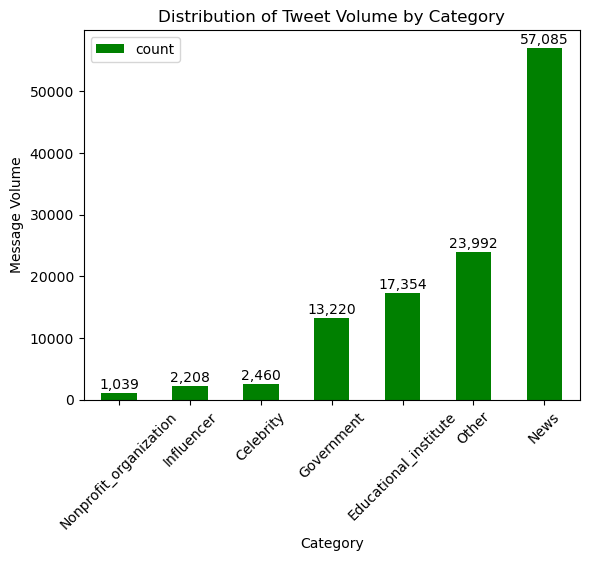

In [27]:
import matplotlib.pyplot as plt
fig = message_by_group.plot(kind='bar', color = 'green', legend = 'Tweet count')
fig.set_xlabel('Category')
fig.set_ylabel('Message Volume')
fig.set_title('Distribution of Tweet Volume by Category')
fig.set_xticklabels(message_by_group.Category, rotation=45)
fig.bar_label(fig.containers[0], labels=[f'{x:,.0f}' for x in fig.containers[0].datavalues], label_type='edge', padding=1)
plt.show()

In [13]:
retweet_by_group = (tweets_categ_ver.filter(f.col('is_retweet'))
                          .filter(~f.col('is_reply'))
                          .groupby(['retweeted_from', 'tweet_text']) # For each user_name and tweet_text combination
                          .agg(
                              # Each 'retweeted_from' user should have the same description and thus the same classification of user type
                              f.max('Category').alias('Category'), 
                              f.max('retweet_count').alias('retweet_count') # Take the max value the retweet_count for each combination
                          ))
retweet_by_group.limit(10)

retweeted_from,tweet_text,Category,retweet_count
0bj3ctivity,discovered influe...,Other,2369
0liviajulianna,able attend first...,Educational_insti...,13
1023WBAB,teacher burnout l...,News,1
10TV,target kohls anno...,Other,4
11KBW,laura jane addo d...,Government,2
11NDRF_VARANASI,11ndrf varanasi c...,Other,2
11NDRF_VARANASI,11ndrf varanasi c...,Other,3
11NDRF_VARANASI,11ndrf varanasi c...,Other,3
11NDRF_VARANASI,11ndrf varanasi c...,Other,2
11NDRF_VARANASI,11ndrf varanasi c...,Other,4


In [14]:
retweet_by_group = (retweet_by_group.groupby('Category')
                                    .agg(sum('retweet_count').alias('retweet_count'))\
                                    .orderBy('retweet_count', ascending=True)).toPandas()
retweet_by_group

,Category,retweet_count
0,Nonprofit_organization,30267
1,Educational_institute,94572
2,Influencer,137768
3,Celebrity,196872
4,Government,426510
5,News,1015467
6,Other,6077448


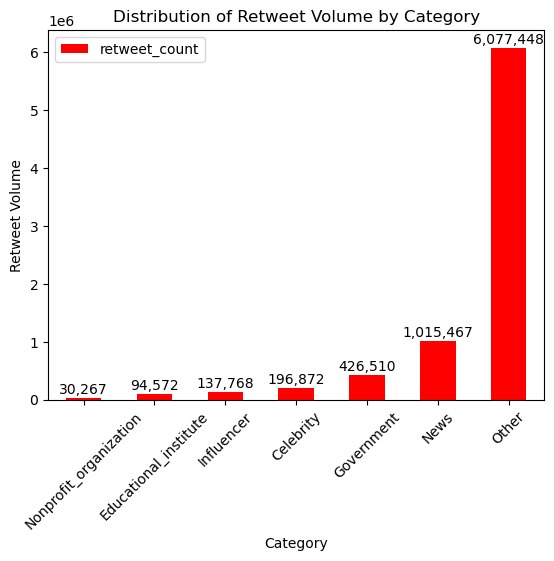

In [16]:
import matplotlib.pyplot as plt
fig = retweet_by_group.plot(kind='bar', color = 'red')
fig.set_xlabel('Category')
fig.set_ylabel('Retweet Volume')
fig.set_title('Distribution of Retweet Volume by Category')
fig.set_xticklabels(retweet_by_group.Category, rotation=45)
fig.bar_label(fig.containers[0], labels=[f'{x:,.0f}' for x in fig.containers[0].datavalues], label_type='edge', padding=1)
plt.show()

In [16]:
tweets_categ_ver.filter(f.col('is_retweet'))\
                          .filter(~f.col('is_reply'))\
                          .groupby('Category')\
                          .agg(
                              f.countDistinct('tweet_id').alias('count'),
                              f.max('user_name').alias('user_name'),
                              f.max('user_description').alias('user_description'),
                              f.max('tweet_text').alias('tweet_text')
                          ).select(['user_name','user_description','tweet_text','Category','count'])\
                          .orderBy('count', ascending=True).toPandas()

,user_name,user_description,tweet_text,Category,count
0,♿ Dev Ramsawakh 🏳️‍⚧️ #SpinaBifiDears,zeta music enthusiast naacp director environmental climate justice lawfoundationsv aclu norcal crpe ej naacp ldf alum treempowerment she her,yr 5 children cathedral school st mary great time nmaplymouth part wideninghorizons yesterday children got go behind scenes amp talk employees find millfieldsinspired plymouthschool socialenterprise,Nonprofit_organization,654
1,🧚🏻‍♀️ Kieran Galpin 🧚🏻‍♀️,youve reached morris coffee person recording artist creator of goombawave barb pop culture hungry try my coffee 100 unblocks,zim hero poor boy zimbabwean cecil sibanda walked 3hours day school empty stomach working us hes spent 8 years building school matabeleland kids dont far walk open form 1 pupils building continues,Influencer,3086
2,🪩🆃🆁🆄🅳🆈🪩,yup that cricket guy instagram jatin sapru fb jatinsapruofficial queries js gmail com,zombie king77 briancohalloran trentonprfm princeton university student misrach ewunetie missing 5 days last seen campus near scully hall,Celebrity,3973
3,🦂🇭🇹🦦,yuvasena secretary aut loyalist greenheart advocate hospitality graduate k9 lover car aficionado musically inclined,zuri johnson born doctors told family hed never talk walk spring hell walk across stage accept high school diploma powerful story student would give incredible mother ourccs read,Educational_institute,10880
4,🪶 OTEP SHAMAYA 🌻,zonal office of press information bureau pib india m o information broadcasting mib india government of india mumbai maharashtra,zobber37 ed onoja ogbeni ogugu village comes roads asphalt even go dropped community school field abi make tar school field una use una head even background see bikes pass asphalt road,Government,13170
5,🩴 Annie Parker 🩴,zora oneill writer editor arabic refugees travel typographical jokes i now regret no relation to zoramag but ill rt she her mastodon zora mas to,zuzana skvarkova spring 2022 outstanding undergraduate school future innovation society graduation plans become physician continue work disability rights activist asugrad,Other,24339
6,🧩 Raisa Habersham 🐾🐾🐾,zulu tsonga muslim former health science journalist intersectional feminist jazz and telenovela lover freepalestine abdullah ibrahim stan,zoom person state capitol parents pressing university minnesota leaders continuing crime issues near campus listening session hosted regent james farnsworth school forum scheduled next week kare11,News,26901


In [28]:
#Checking retweet counts for verified users only
tweets_categ_ver.filter(f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'News')\
                .groupby('user_id')\
                .agg(
                    f.max('user_name').alias('user_name'),
                    f.max('retweeted_from').alias('retweeted_from'),
                    f.max('tweet_text').alias('tweet_text'),
                    f.max('retweet_count').alias('retweet_count')
                          )\
                .select(['user_name','retweeted_from', 'tweet_text', 'retweet_count'])\
                .orderBy('retweet_count', ascending=False).limit(5).toPandas()

,user_name,retweeted_from,tweet_text,retweet_count
0,Liam Warren,thomas_violence,love little cultural differences like americans super offended word cunt australia super offended school children slaughtered automatic weapons,143552
1,Kristen Parisi☕️,loeytaro,today honored join disability advocates including disrightstx press conference condemn use restraints children public schools want especially thank families shared heartbreaking stories children s...,71668
2,Paul Armstrong,mattxiv,school barcelona installed solar panels roof generating enough energy power school 30 houses surrounding area,71055
3,Atlanta Del Rey,mattxiv,florida high school class president zander moricz told school would cut microphone said gay grad speech replaced gay curly hair awe,70537
4,Juan Martinez,mattxiv,florida high school class president zander moricz told school would cut microphone said gay grad speech replaced gay curly hair awe,70374


In [29]:
tweets_categ_ver.filter(f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Celebrity')\
                .groupby('user_id')\
                .agg(
                    f.max('user_name').alias('user_name'),
                    f.max('retweeted_from').alias('retweeted_from'),
                    f.max('tweet_text').alias('tweet_text'),
                    f.max('retweet_count').alias('retweet_count')
                          )\
                .select(['user_name','retweeted_from', 'tweet_text', 'retweet_count'])\
                .orderBy('retweet_count', ascending=False).limit(5).toPandas()

,user_name,retweeted_from,tweet_text,retweet_count
0,Abhinav Khare,mattxiv,florida high school class president zander moricz told school would cut microphone said gay grad speech replaced gay curly hair awe,65582
1,Callie Khouri 🇺🇦,notcapnamerica,wife paid degrees wife paid degrees wife paid sons college degree wife pay kids college degree know good want live educated society,63797
2,Jeri Ryan,tlecaque,total perfection long thread columnist forgiving student loans bad followed parents paid college tuition,62817
3,Martha Madison,mattxiv,florida high school class president zander moricz told school would cut microphone said gay grad speech replaced gay curly hair awe,61104
4,Maureen McCormick,RexChapman,young man severely colorblind studying colorblindness class school principal brought glasses allowed youngster see color first time twitter content,59774


In [30]:
tweets_categ_ver.filter(f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Influencer')\
                .groupby('user_id')\
                .agg(
                    f.max('user_name').alias('user_name'),
                    f.max('retweeted_from').alias('retweeted_from'),
                    f.max('tweet_text').alias('tweet_text'),
                    f.max('retweet_count').alias('retweet_count')
                          )\
                .select(['user_name','retweeted_from', 'tweet_text', 'retweet_count'])\
                .orderBy('retweet_count', ascending=False).limit(5).toPandas()

,user_name,retweeted_from,tweet_text,retweet_count
0,Jeena Cho 조지현,ClintSmithIII,elementary school children woke morning ate favorite cereal tied shoes double knots laughed friends bus dozen dead normal way keep way,67709
1,Margaret Owen ✨Briefly @ ECCC!,mattxiv,florida high school class president zander moricz told school would cut microphone said gay grad speech replaced gay curly hair awe,67154
2,Austin Highsmith Garces,ClintSmithIII,elementary school children woke morning ate favorite cereal tied shoes double knots laughed friends bus dozen dead normal way keep way,65449
3,🦈👑 Nidhi Chanani preorder SHARK PRINCESS,mhdksafa,sorry talk roe v wade right finish article millions children go hungry summer congress extended school nutrition waivers provided free school meals children regardless income,60124
4,Jennifer Nadel 💙,NasimiShabnam,male university students walked exam protest taliban decision ban female students university education several male professors also resigned far must happen across country,58708


In [31]:
tweets_categ_ver.filter(f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Government')\
                .groupby('user_id')\
                .agg(
                    f.max('user_name').alias('user_name'),
                    f.max('retweeted_from').alias('retweeted_from'),
                    f.max('tweet_text').alias('tweet_text'),
                    f.max('retweet_count').alias('retweet_count')
                          )\
                .select(['user_name','retweeted_from', 'tweet_text', 'retweet_count'])\
                .orderBy('retweet_count', ascending=False).limit(5).toPandas()

,user_name,retweeted_from,tweet_text,retweet_count
0,Dr. Frank Mugisha,nickopiyo,thank fletcher school law diplomacy today excellent lecture fantastic group students,70842
1,Alana DiMario,virtualham,teacher social media observation definitely aimed anyone school boards want teachers care emotional physical needs students good start would caring emotional physical needs teachers,70792
2,Melanie Amann,mattxiv,florida high school class president zander moricz told school would cut microphone said gay grad speech replaced gay curly hair awe,66333
3,Jenny Yang's Comedy Crossing LIVE Thur May 26,mattxiv,florida high school class president zander moricz told school would cut microphone said gay grad speech replaced gay curly hair awe,65519
4,Ester Bloom,ClintSmithIII,elementary school children woke morning ate favorite cereal tied shoes double knots laughed friends bus dozen dead normal way keep way,64619


In [32]:
tweets_categ_ver.filter(f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Educational_institute')\
                .groupby('user_id')\
                .agg(
                    f.max('user_name').alias('user_name'),
                    f.max('retweeted_from').alias('retweeted_from'),
                    f.max('tweet_text').alias('tweet_text'),
                    f.max('retweet_count').alias('retweet_count')
                          )\
                .select(['user_name','retweeted_from', 'tweet_text', 'retweet_count'])\
                .orderBy('retweet_count', ascending=False).limit(5).toPandas()

,user_name,retweeted_from,tweet_text,retweet_count
0,Fitsum Areguy,miss_macro,social work version mean girls high school became nurses women work disabled children endorse aba,54694
1,Christopher Michel,nytimesbooks,meet john dabiri phd nigerian professor civil amp environmental mechanical engineering stanford university,53322
2,PJ Byrne,MichaelWarbur17,2006 high school english teacher asked students write famous author amp ask advice kurt vonnegut one respond reply doozy,50764
3,Manu Bhagavan,mjs_DC,ta nehisi coates one greatest non fiction writers time also college board purged work ap test governor wants erase black history think heading leaders higher education dont fight back,50725
4,Sophia Gad-Nasr,QasimRashid,keenan anderson 31 year old high school teacher amp father stopped la police help accident instead cuffed pinned amp tased repeatedly begged stop keenan died cardiac arrest excessive tasing crime ...,49708


In [33]:
tweets_categ_ver.filter(f.col('is_retweet'))\
                .filter(~f.col('is_reply'))\
                .filter(f.col('Category') == 'Nonprofit_organization')\
                .groupby('user_id')\
                .agg(
                    f.max('user_name').alias('user_name'),
                    f.max('retweeted_from').alias('retweeted_from'),
                    f.max('tweet_text').alias('tweet_text'),
                    f.max('retweet_count').alias('retweet_count')
                          )\
                .select(['user_name','retweeted_from', 'tweet_text', 'retweet_count'])\
                .orderBy('retweet_count', ascending=False).limit(5).toPandas()

,user_name,retweeted_from,tweet_text,retweet_count
0,Roberto Abramowitz,mattxiv,nyc teachers criticize massive school budget cuts nyc mayor adams cutting public school budgets benefit charter schools charter billionaires contributed generously campaign leoniehaimson nyarteacher,70435
1,Carlos León Moya,ChicksRule,teaching sex ed school make kids want sex yeah right math school really made wanna math hard time,29433
2,Nicholas Pinnock,MichaelWarbur17,2006 high school english teacher asked students write famous author amp ask advice kurt vonnegut one respond reply doozy,16499
3,Raffi Cavoukian,Mylovanov,wrong teach japanese american internment spent whole life telling story damned let fool school board meeting refuse let kids hear happened us truth people teach truth,14734
4,Student Debt Crisis Center (SDCC),Echelon_MEW,nope 61 voters without college degree broadly support canceling student debt 58 voters owe student debt amp 57 voters 45 lets make things yall already polled,13403


### Writing the Classified data to disk

In [19]:
tweets_categ.write.format("parquet").\
mode('overwrite').\
save('gs://' + 'msca-bdp-students-bucket/shared_data/pranavr569' + '/tweets_classified')

In [13]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified' | head

Found 116 items
-rwx------   3 root root          0 2023-03-04 21:36 gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified/_SUCCESS
-rwx------   3 root root  119521517 2023-03-04 21:26 gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified/part-00000-7f688498-d848-44b7-a88b-e15f9a6d6219-c000.snappy.parquet
-rwx------   3 root root  117375672 2023-03-04 21:26 gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified/part-00001-7f688498-d848-44b7-a88b-e15f9a6d6219-c000.snappy.parquet
-rwx------   3 root root  116324526 2023-03-04 21:26 gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified/part-00002-7f688498-d848-44b7-a88b-e15f9a6d6219-c000.snappy.parquet
-rwx------   3 root root  115969872 2023-03-04 21:26 gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified/part-00003-7f688498-d848-44b7-a88b-e15f9a6d6219-c000.snappy.parquet
-rwx------   3 root root  115778406 2023-03-04 21:26 gs://msca-bdp-students-bucket/